In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import defaultdict
import copy

In [2]:
class BurgersPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

Epoch: 1/200 | Total loss: 0.282 | Physics loss: 0.0 | Initial loss: 0.255 | Boundary loss: 0.027 
Epoch: 51/200 | Total loss: 0.001 | Physics loss: 0.0 | Initial loss: 0.001 | Boundary loss: 0.0 
Epoch: 101/200 | Total loss: 0.0 | Physics loss: 0.0 | Initial loss: 0.0 | Boundary loss: 0.0 
Epoch: 151/200 | Total loss: 0.0 | Physics loss: 0.0 | Initial loss: 0.0 | Boundary loss: 0.0 


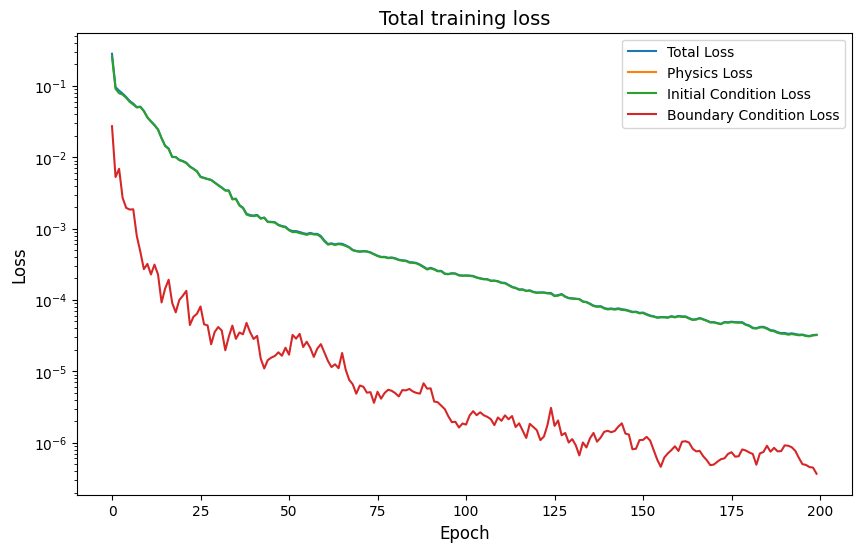

In [3]:
class PhysicsInformedBurgers:
    def __init__(self, nu=0.01/np.pi):
        self.nu = nu
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BurgersPINN().to(self.device)

        self.loss_history = defaultdict(list)
        self.saved_models = []

    def compute_derivatives(self, u, t, x):
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs = torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs = torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs = torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        return u_t, u_x, u_xx

    def physics_loss(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        u = self.model(torch.cat([t, x], dim=1))
        u_t, u_x, u_xx = self.compute_derivatives(u, t, x)

        residual = u_t + u * u_x - self.nu * u_xx
        physics_loss = torch.mean(residual**2)
        return physics_loss

    def initial_condition_loss(self, t0, x0):
        u_pred = self.model(torch.cat([t0, x0], dim=1))
        u_true = -torch.sin(np.pi * x0) # IC u(0, x) = -sin(pi*x)
        return torch.mean((u_pred - u_true)**2)

    def boundary_condition_loss(self, t_bc, x_bc_left, x_bc_right):
        u_left = self.model(torch.cat([t_bc, x_bc_left], dim=1))
        loss_left = torch.mean(u_left**2) # u)(t, -1) = 0

        u_right = self.model(torch.cat([t_bc, x_bc_right], dim=1))
        loss_right = torch.mean(u_right**2) # u(t,1)=0

        return loss_left + loss_right

    def generate_training_data(self, n_collocation=10**(4), n_initial=500, n_boundary=500):
        t_c = torch.rand(n_collocation, 1, device=self.device) 
        x_c = torch.rand(n_collocation, 1, device=self.device) * 2 - 1
        # IC
        t0 = torch.zeros(n_initial, 1, device=self.device)
        x0 = torch.rand(n_initial, 1, device=self.device) * 2 - 1
        # BC
        t_bc = torch.rand(n_boundary, 1, device=self.device)
        x_bc_left = torch.full((n_boundary, 1), -1.0, device=self.device)
        x_bc_right = torch.full((n_boundary, 1), 1.0, device=self.device)

        return {
            'collocation': (t_c, x_c),
            'initial': (t0, x0), 
            'boundary': (t_bc, x_bc_left, x_bc_right)
        }

    def compute_losses(self, data):
        t_c, x_c = data['collocation']
        t0, x0 = data['initial']
        t_bc, x_bc_left, x_bc_right = data['boundary']
        with torch.no_grad():
            self.model.eval()
            u_initial_pred = self.model(torch.cat([t0, x0], dim=1))
            u_initial_true = -torch.sin(np.pi * x0)
            loss_initial = torch.mean((u_initial_pred - u_initial_true)**2)

            u_left = self.model(torch.cat([t_bc, x_bc_left], dim=1))
            u_right = self.model(torch.cat([t_bc, x_bc_right], dim=1))
            loss_boundary = torch.mean(u_left**2) + torch.mean(u_right**2)

            u_collocation = self.model(torch.cat([t_c, x_c], dim=1))
            loss_physics = torch.tensor(0.0, device=self.device)
            total_loss = loss_initial + loss_boundary

        self.model.train()
        return total_loss.item(), loss_physics.item(), loss_initial.item(), loss_boundary.item()

    def train(self, epochs=1000, lr=1.0, save_interval=10):
        data = self.generate_training_data()
        t_c, x_c = data['collocation']
        t0, x0 = data['initial']
        t_bc, x_bc_left, x_bc_right = data['boundary']
        
        optimizer = optim.LBFGS(self.model.parameters(), lr=lr, line_search_fn = 'strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss_physics = self.physics_loss(t_c, x_c)
            loss_initial = self.initial_condition_loss(t0, x0)
            loss_boundary = self.boundary_condition_loss(t_bc, x_bc_left, x_bc_right)
            total_loss = loss_physics + loss_initial + loss_boundary
            total_loss.backward()
            return total_loss

        for epoch in range(epochs):
            current_loss = optimizer.step(closure)
            total_loss, loss_physics, loss_initial, loss_boundary = self.compute_losses(data)
            self.loss_history['total'].append(total_loss)
            self.loss_history['physics'].append(loss_physics)
            self.loss_history['initial'].append(loss_initial)
            self.loss_history['boundary'].append(loss_boundary)
            if epoch % save_interval == 0 or epoch == epochs - 1:
                self.saved_models.append({'epoch': epoch, 'model_state': copy.deepcopy(self.model.state_dict()), 'loss': total_loss})

            if epoch % 50 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Total loss: {np.round(total_loss, 3)} | Physics loss: {np.round(loss_physics, 3)} | Initial loss: {np.round(loss_initial, 3)} | Boundary loss: {np.round(loss_boundary, 3)} ')

    def predict(self, t, x, model_state=None):
        if model_state != None:
            original_state = copy.deepcopy(self.model.state_dict())
            self.model.load_state_dict(model_state)
        
        self.model.eval()
        with torch.no_grad():
            t_tensor = torch.tensor(t, dtype=torch.float32, device=self.device).unsqueeze(-1)
            x_tensor = torch.tensor(x, dtype=torch.float32, device=self.device).unsqueeze(-1)
            u_pred = self.model(torch.cat([t_tensor, x_tensor], dim=1))
        if model_state != None:
            self.model.load_state_dict(original_state)      
        return u_pred.cpu().numpy()
    
    def plot_loss_history(self):
        plt.figure(figsize=(10, 6))
        epochs = range(len(self.loss_history['total']))
        plt.semilogy(epochs, self.loss_history['total'], label='Total Loss')
        plt.semilogy(epochs, self.loss_history['physics'], label='Physics Loss')
        plt.semilogy(epochs, self.loss_history['initial'], label='Initial Condition Loss')
        plt.semilogy(epochs, self.loss_history['boundary'], label='Boundary Condition Loss')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Total training loss', fontsize=14)
        plt.legend()
        plt.show()

    def create_animation(self, n_frames=50):
        x_vis = np.linspace(-1, 1, 1000)
        exact_solution = -np.sin(np.pi * x_vis)
        model_states = self.saved_models
        if len(model_states) > n_frames:
            indices = np.linspace(0, len(model_states)-1, n_frames, dtype=int)
            model_states = [model_states[i] for i in indices]
        fig, ax = plt.subplots(figsize=(10, 6))
        
        def animate(frame):
            ax.clear()
            model_info = model_states[frame % len(model_states)]
            epoch = model_info['epoch']
            model_state = model_info['model_state']
            loss = model_info['loss']
            u_pred = self.predict(np.zeros_like(x_vis), x_vis, model_state=model_state).flatten()
            
            ax.plot(x_vis, exact_solution, 'k-', linewidth=3, label='Exact Solution')
            ax.plot(x_vis, u_pred, 'r--', linewidth=2, label='PINN Prediction')
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1.2, 1.2)
            ax.set_xlabel('x')
            ax.set_ylabel('u(0,x)')
            ax.set_title(f'Predicted initial condition at: Epoch: {epoch} | Loss: {np.round(loss, 3)}')
            ax.legend(loc='upper right')
            return ax,
        
        anim = FuncAnimation(fig, animate, frames=len(model_states), interval=250, blit=False)
        plt.close()
        return anim


if __name__ == "__main__":
    pinn = PhysicsInformedBurgers()
    pinn.train(epochs=200, lr=1.0, save_interval=5)
    pinn.plot_loss_history()
    
    anim = pinn.create_animation()
    if anim is not None:
        anim.save('Burger_initial_condition.gif', writer='pillow', fps=4)